In [1]:
import pandas as pd
import MeCab
from gensim import models

df = pd.read_csv("../data/tweets.csv")
mecab = MeCab.Tagger ("-Owakati")
print(mecab.parse("pythonが大好きです"))

df = df[pd.isnull(df.retweeted_status_id)]
df = df[pd.isnull(df.in_reply_to_status_id)]
df = df[df.text.str.find("http")==-1]

for index, row in df.iterrows():
    if not pd.isnull(row.text):
        df.set_value(index, "text", mecab.parse(row["text"]))        
        
for index, row in df.iterrows():
    if not pd.isnull(row.text):
        print(row.text)
    if index > 10 : break;

python が 大好き です 

無理 だ ー 

人間 よ 、 24 に 、 分類 さ れよ ！ 

計算 中 ・ ・ ・ 

えい 、 ` from scipy . cluster . vq import vq , kmeans , whiten ` 

k - means やる ぞ 

お は よー ！ 6 h 28 m ね た よ ！ January 27 , 2016 at 01 : 19 AM → January 27 , 2016 at 08 : 06 AM 

ねむい ー 

Doc 2 Vec の 基底 ベクトル は Word 2 Vec の それ と 一緒 っぽい な 



In [2]:
df.to_csv("../data/formatted_tweets.csv")

In [3]:
import itertools
class LabeledLineSentence(object):
    def __init__(self, df):
        self.df = df

    def __iter__(self):
        for index, row in self.df.iterrows():            
            yield models.doc2vec.LabeledSentence(row["text"].split(), ['text_%s' % index])
            

sentence = LabeledLineSentence(df)
print(list(sentence)[:5])
len(df)

[LabeledSentence(words=['無理', 'だ', 'ー'], tags=['text_1']), LabeledSentence(words=['人間', 'よ', '、', '24', 'に', '、', '分類', 'さ', 'れよ', '！'], tags=['text_2']), LabeledSentence(words=['計算', '中', '・', '・', '・'], tags=['text_3']), LabeledSentence(words=['えい', '、', '`', 'from', 'scipy', '.', 'cluster', '.', 'vq', 'import', 'vq', ',', 'kmeans', ',', 'whiten', '`'], tags=['text_4']), LabeledSentence(words=['k', '-', 'means', 'やる', 'ぞ'], tags=['text_5'])]


8423

In [4]:
from gensim import models
model = models.Doc2Vec()
model.build_vocab(sentence)

for _ in range(10):
    model.train(sentence)
    print("トレーニング" + str(_) + "終了")

トレーニング0終了
トレーニング1終了
トレーニング2終了
トレーニング3終了
トレーニング4終了
トレーニング5終了
トレーニング6終了
トレーニング7終了
トレーニング8終了
トレーニング9終了


In [5]:
# model.vocab.keys()

In [6]:
model.most_similar("リクルート")

[('文章', 0.692463219165802),
 ('楽天', 0.6528801918029785),
 ('普通', 0.6480002999305725),
 ('向こう', 0.6456928253173828),
 ('ruby', 0.63555908203125),
 ('秋', 0.6347962021827698),
 ('銀座', 0.6258277297019958),
 ('最後', 0.6216842532157898),
 ('大学', 0.6193414926528931),
 ('写真', 0.6091267466545105)]

In [7]:
base = "text_1"
key, index = base.split("_")
print(df.ix[int(index)][key])
for offset, similality in model.docvecs.most_similar(base):
    doctag = model.docvecs.offset2doctag[offset]
    key, index = doctag.split("_")
    print("%s%%"%int(similality*100),df.ix[int(index)][key])

無理 だ ー 

84% 無料 で 遊ん だ ー 

72% NSTimer が 動か ない 。 なんで だ ー 。 

71% これ 、 デジャブ だ 　 RT @ hbkr : あけ まし て おめでとう ござい ます 

68% 今日 は 、 ビール だ ぞ ー ！ 

68% だ だ し 、 Template 系 が 入ら ない なぁ 。 

66% 二 次 多項式 じゃ なく て も 、 この 命題 成り立っ て くれ ー 。 

66% Charles 買っ た ー 

65% ネット が 遅い 。 なんで だ ー 

65% 駄目 だ camphchat が 動か ない 。 なんで だ 

64% 紅白 が はじまっ た みたい だ 



In [8]:
from scipy.cluster.vq import vq, kmeans, whiten
centroid, destortion = kmeans(model.docvecs, 10 , iter=100, thresh=1e-05)

In [9]:
labels, dist = vq(model.docvecs, centroid)
print(labels[:5]) # どのクラスターに入ってるか
print(dist[:5]) # 中心からの距離

[7 4 0 6 7]
[ 0.30013314  0.36538607  0.22260441  0.28419262  0.30240995]


In [10]:
df = pd.read_csv("../data/tweets.csv")
for label in range(10):
    print(label,"スタート")
    print_i = 0
    for i in range(model.docvecs.count):
        if labels[i] == label:
            dist_vec = vq([model.docvecs[i]], centroid)
            doctag = model.docvecs.offset2doctag[i]
            key, index = doctag.split("_")
            if int((1.-dist[i])*100) and not pd.isnull(df.ix[int(index)][key]):
#                 print(dist_vec)
                print("%s%%"%int((1.-dist[i])*100),df.ix[int(index)][key].strip("\t\n"))
                print_i +=1
                if print_i > 3 : 
                    print("\n");break;

0 スタート
77% 計算中・・・
73% 聴き終わった
69% おはよー！ 8h 31m ねたよ！ January 25, 2016 at 01:09AM →January 25, 2016 at 09:52AM
76% フェスは負けまくってる


1 スタート
81% えっーっと、やこです！！！
80% タイガーナッツ気になる
61% LINEの鍵のやつ、LINEでできるようになったってのもやばいけど、そもそも写真から鍵作れるの、そもそもやばくない？

技術的には可能だった、ってことよね
71% みんな電子タバコにしてくんないかな


2 スタート
58% ウィスキー！
71% 鍵って、鍵番号だけで複製できるのか。

写真から、3Dを再現して、作るんかと思った。
70% プロダクションでObjC→Swiftにしたところってあるのかな。
66% 企業としては、HackerNews的なキュレーションで良いと思うんだな。

今週の社員が、気になった記事みたいなのみたいなまとめとかで。

そこに質の高い記事を社員が書いたらピックアップしておく。


3 スタート
61% おはよー！ 6h 28m ねたよ！ January 27, 2016 at 01:19AM →January 27, 2016 at 08:06AM
69% おはよー！ 5h 57m ねたよ！ January 26, 2016 at 01:34AM →January 26, 2016 at 07:46AM
67% おはよー！ 6h 49m ねたよ！ January 23, 2016 at 02:25AM →January 23, 2016 at 09:37AM
72% おはよー！ 7h 53m ねたよ！ January 22, 2016 at 01:10AM →January 22, 2016 at 09:21AM


4 スタート
63% 人間よ、24に、分類されよ！
66% POSTDのパーカーはポッドキャストに出ればもらえるらしい
73% フェス、カンペキカラダ、勝った！！
71% 大麦にはグルテンが入ってない！


5 スタート
74% ぶっちゃけ感w
70% 個人でやってるブログが良いことが多いことが多い気がする。それで会社に興味持つ流れのほうが自然だわなぁ、って気はする。
72% という超ど

In [11]:
import numpy as np
sim_matrix = []
size = model.docvecs.count
for i in range(model.docvecs.count):
    sim_vec = np.zeros(size)
    for word_index, sim_val in model.docvecs.most_similar(i):
        sim_vec[word_index] = sim_val
    sim_matrix.append(sim_vec)

In [12]:
from sklearn.decomposition import TruncatedSVD
dimension = 100
lsa = TruncatedSVD(dimension)
info_matrix = lsa.fit_transform(sim_matrix)

In [13]:
centroid, destortion = kmeans(info_matrix, 10 , iter=100, thresh=1e-05)

In [14]:
labels, dist = vq(info_matrix, centroid)
print(labels[:5]) # どのクラスターに入ってるか
print(dist[:5]) # 中心からの距離

[8 0 8 8 8]
[ 1.13863846  1.08749985  0.82436281  0.19778844  0.47748427]


In [15]:
df = pd.read_csv("../data/tweets.csv")
for label in range(10):
    print(label,"スタート")
    print_i = 0
    for i in range(model.docvecs.count):
        if labels[i] == label:
            doctag = model.docvecs.offset2doctag[i]
            key, index = doctag.split("_")
            if int((1.-dist[i])*100) and not pd.isnull(df.ix[int(index)][key]):
#                 print(dist_vec)
                print("%s%%「"%int((1.-dist[i])*100),df.ix[int(index)][key].strip("\t\n"),"」")
                print_i +=1
                if print_i > 4 : break;
    print("\n");

0 スタート
-8%「 人間よ、24に、分類されよ！ 」
37%「 えっーっと、やこです！！！ 」
-109%「 ウィスキー！ 」
43%「 プロダクションでObjC→Swiftにしたところってあるのかな。 」
-3%「 ランニング→水泳→自炊→スプラトゥーン 」


1 スタート
3%「 macのプロセスを監視して、デイリーでレポーティングしてくれるサービス欲しい。今日はXcodeと4時間、chromeと2時間みたいな。顔認識して、画面の前にいる時だけトラッキングとかして欲しいけど、省メモリで。 」
15%「 MBA捕獲。これで青色申告できなかったらツライ。

がんばって、青色やろう。10だと、白色と変わらなそうだし。 」
2%「 明日、親知らずを抜くという、ミッションが。。。 」
-22%「 はじめまして。そして、はじめまして。 」
21%「 パソコンが熱すぎてやばい。。。おおお 」


2 スタート
15%「 公式の見解 」
19%「 PycharmのiPytnon notebookのundoingが予想外の動きをして、何回もめっちゃ戻ってる。。。

やっぱ、webでコード書くか 」
8%「 夢で確率論を勉強していた

赤色の本だったけど、そんなのあったっけ 」
20%「 WildCardのadhocでiTCのバリデーション通るって・・・ 」
18%「 家の近くに、温泉の湧き水ほしい 」


3 スタート
-6%「 なんでや 」
-2%「 とりあえずスクワットと戦士のポーズしておいた 」
37%「 S3でhubotってどういうことだろ 」
-40%「 深層っていう日本語訳あってるか。層じゃなくね 」
16%「 @i2key おお、これすごい！いろいろいい感じのがはいってる！ 」


4 スタート
10%「 フェス、カンペキカラダ、勝った！！ 」
26%「 お亡くなりになられた。ありがとう、TestFlight！

iTunesの便利だけど、使い道が違うから、次は、fabric.ioかなと思ってるよ。 」
27%「 HYDEあとちょっとで、どらげない、やった 」
-27%「 うごけ、スタバ 」
-14%「 PyCharm、なんで、workonせんのや？ 」


5 スタート
22%「 ねむいー 」
-5%「 BABAQおもろい 」
22%「 1,2月が一番寒いの

In [16]:
import sklearn.decomposition
pca = sklearn.decomposition.PCA(n_components = 2)  # 主成分分析オブジェクトの作成
pca.fit(info_matrix)                       # 主成分分析の実行
transformed = pca.transform(info_matrix)   # データに対して削減後のベクトルを生成

8423
8423
-0.0394479139388 0.0284205229064


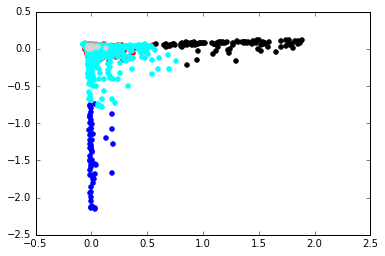

In [29]:
%matplotlib inline

import matplotlib.pyplot as plt

print(len(transformed))
print(model.docvecs.count)
print(transformed[0][0],transformed[0][1])

colors = ["red", "blue", "green", "yellow", "black", "white", "darkgray","magenta", "cyan", "lightgray"]

for label in range(10):
    for i in range(model.docvecs.count):
        if labels[i] == label:
            plt.scatter(transformed[i][0], transformed[i][1], color=colors[label], marker="o", label=str(i))
            
plt.show()

In [31]:
for i in range(model.docvecs.count):
    if labels[i] == 1:
        doctag = model.docvecs.offset2doctag[i]
        key, index = doctag.split("_")
        if int((1.-dist[i])*100) and not pd.isnull(df.ix[int(index)][key]):
#                 print(dist_vec)
            print("%s%%「"%int((1.-dist[i])*100),df.ix[int(index)][key].strip("\t\n"),"」")
            print_i +=1
            if print_i > 100 : break;
print("\n");

3%「 macのプロセスを監視して、デイリーでレポーティングしてくれるサービス欲しい。今日はXcodeと4時間、chromeと2時間みたいな。顔認識して、画面の前にいる時だけトラッキングとかして欲しいけど、省メモリで。 」
15%「 MBA捕獲。これで青色申告できなかったらツライ。

がんばって、青色やろう。10だと、白色と変わらなそうだし。 」
2%「 明日、親知らずを抜くという、ミッションが。。。 」
-22%「 はじめまして。そして、はじめまして。 」
21%「 パソコンが熱すぎてやばい。。。おおお 」
17%「 原点回帰。 」
-26%「 レスポンシブやで。レスポンシブ。 」
25%「 しまった。tagじゃなくて、branchにしておけばよかった。。。 」
39%「 ShareKit、Twitterframeworkとか、SocialFrameworkとか使ってないのか。。。 」
51%「 backlogよ、markdownに対応してください。ほんとに。まじで。対応してほしい。 」
33%「 cocos2dxで、ローカライズってどうすれば。。。 」
54%「 アーロンチェア買っといてよかったー。やる気の度合いが違う。むしろ、お家のほうが好き。 」
22%「 おいおい。。。。 」
63%「 オリジン弁当はピンク色がだめ。けど、今度買ってみよう。 」
19%「 そういえば、海外から取り寄せた、ヘッドフォンのコードがぶらーとならないやつが、なかなか届きません。。。お金払ってるのに、、どゆこと。 」
59%「 SonicMaxProええなー。低音きれい。 」
54%「 サーバー苦手。 」
9%「 すっごいねた。 」
31%「 Validate通らない。。。。 」
56%「 C++のテンプレートが何故か使えない。Linkerエラーってなる？何故に。。。 」
65%「 C++が分かりませんorz。。。 」
43%「 au予約できない。。。 」
60%「 なんか、簡単な対処法は。。。 」
40%「 Appleのばかー。。。。あるていど、相対レイアウトで組んでるから、まだマシだが。。。あぁ、もう！これ、まずいぞ。。。。ばかー。。。 」
51%「 あれ？僕も、_はアンスコって呼びます。。。？？ 」
34%「 retina、外部ディスプレイをつなげると解像度が変わるのやめて欲し